# `photoeccentric` Tutorial

In this tutorial, I will create a simulated transit based on a Kepler planet and demonstrate how to use `photoeccentric` to recover a planet's eccentricity posterior using the photoeccentric effect [(Dawson & Johnson 2012)](https://arxiv.org/pdf/1203.5537.pdf).

The code I'm using can be viewed/downloaded here: https://github.com/ssagear/photoeccentric

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
import astropy.units as u
import os
import scipy
import random

import corner

import photoeccentric as ph

%load_ext autoreload
%autoreload 2

# pandas display option
pd.set_option('display.float_format', lambda x: '%.5f' % x)

lcpath = '../datafiles/sample_lcs'


## Defining a "test planet"


I'm going to pick a planet from our sample to test how well `photoeccentric` works. Here, I'm picking KOI 818.01 (Kepler-691 b), a super-Earth orbiting an M dwarf. It has an orbital period of about 8 days.

[KOI 818.01 Exoplanet Catalog Entry](https://exoplanets.nasa.gov/exoplanet-catalog/4987/kepler-818-b/)

In [2]:
nkoi = 818.01

I'll read in a file with the stellar information.

In [3]:
mass = 0.56454
radius = 0.55833
rho_star = ph.density(mass, radius)
rho_star_err = 1

I'll define a KeplerStar object with `ph.KeplerStar(skoi)`, where `skoi` is the integer KOI identifier (818 for KOI 818.01).

In [4]:
SKOI = int(np.floor(float(nkoi)))
print('SKOI', SKOI)

star = ph.KeplerStar(SKOI)

SKOI 818


Now, I can define a KOI object with `ph.KOI(nkoi, SKOI, isodf)` where `nkoi` is the KOI planet identifier (818.01 in this case), `SKOI` is the integer KOI identifier as above, and `isodf` is a `pandas` dataframe constaining the consistent MESA stellar isochrones, which we created above.

The `koi` object will have all the same attributes as the `KeplerStar` object -- defining a `KeplerStar` object is not explicitly necessary.

In [5]:
koi = ph.KOI(nkoi, SKOI)

koi.mstar = mass
koi.rstar = radius
koi.rho_star = rho_star
koi.rho_star_err = rho_star_err

I'm pulling the planet parameters of Kepler-691 b from the exoplanet archive using `ph.planet_params_from_archive()`. This will give me the published period, radius ratio, inclination, and more parameters for this planet.

I can use `koi.get_KIC` to get the Kepler Input Catalog number for the KOI.

And I can use the `koi.download_planet_params()` function to download planet properties from the Exoplanet Archive. The properties will become attributes of the `koi` object.

In [6]:
params = koi.download_planet_params()

print('KIC: ', koi.KIC)
print('Kepler Name: ', koi.kepname)
print('Period (days): ', koi.period)
print('Rp/Rs: ', koi.rprs)
print('a/Rs: ', koi.a_rs)
print('b: ', koi.b)

KIC:  4913852.0
Kepler Name:  ['Kepler-691 b']
Period (days):  8.11437482
Rp/Rs:  0.037204
a/Rs:  23.58
b:  0.573


I can also view all the planet parameters available in the Exoplanet Archive as a `pandas` DataFrame:

In [7]:
params

,kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,...,koi_fpflag_co,koi_fpflag_ec,koi_insol,koi_insol_err1,koi_insol_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_score
0,4913852,K00818.01,Kepler-691 b,288.81201,0.00000,19h15m14.88s,40.03340,0.00000,+40d02m00.2s,17.47400,...,0,0,10.55000,2.46000,-2.31000,3.76716,2.38541,-3.13735,LS+MCMC,1.00000


## Creating a fake light curve based on a real planet

I'm calculating a/Rs using `ph.calc_a()`, instead of using the a/Rs constraint from the Exoplanet Archive. The reason is because a/Rs must be consistent with the density calculated above from spectroscopy/Gaia for the photoeccentric effect to work correctly, and the published a/Rs is often inconsistent. a/Rs depends on the orbital period, Mstar, and Rstar.


Let's force the inclination to be 90 degrees for this example.

In [8]:
koi.calc_a(koi.mstar, koi.rstar)

print('Stellar mass (Msun): ', koi.mstar, 'Stellar radius (Rsun): ', koi.rstar)
print('Period (Days): ', koi.period, 'Rp/Rs: ', koi.rprs)
print('a/Rs: ', koi.a_rs)

# This isn't the true inclination of KOI 818.01, but for this example, we'll create an edge-on transit.
koi.i = 90.
print('i (deg): ', koi.i)

Stellar mass (Msun):  0.56454 Stellar radius (Rsun):  0.55833
Period (Days):  8.11437482 Rp/Rs:  0.037204
a/Rs:  25.131726892963254
i (deg):  90.0


Now, I'll create a fake transit using `batman`.
I'm creating a model with the period, Rp/Rs, a/Rs, and inclination specified by the Kepler catalog entry and the density constraints.

I'll create the transit model with an $e$ and $w$ of my choice. This will allow me to test whether `photoeccentric` accurately recovers the $(e,w)$ combination I have input. I'll start with $e = 0.0$ and $w = 90.0$ degrees.

## Test Case 1: $e = 0.0$, $\omega = 90.0$

I
define a cadence length (~30  minutes, in days) that matches the Kepler long-cadence integration time, so I can create a fake light curve that integrates over the same time as real Kepler light curves.

I want to replicate the real Kepler light curve as closely as possible. So I am taking these parameters fromm the light curves

In [9]:
# Define the working directory
direct = 'tutorial01_Test/' + str(nkoi) + '/e_0.0_w_90.0/'
if not os.path.exists(direct):
    os.makedirs(direct)

First, downloading the light curves

In [10]:
# Stitching the light curves together, preserving the time stamps
koi.download_lightcurves()
koi.get_stitched_lcs()

# Getting the midpoint times
koi.get_midpoints()

COMPLETE:  mastDownload.tar.gz
None


In [11]:
starttime = koi.time[0]
endtime = koi.time[-1]

In [12]:
# 30 minute cadence
cadence = 0.02142857142857143

time = np.arange(starttime, endtime, cadence)

In [13]:
# Define e and w, calculate flux from transit model
e = 0.0
w = 90.0
import batman 

params = batman.TransitParams()       #object to store transit parameters
params.t0 = koi.epoch                 #time of inferior conjunction
params.per = koi.period               #orbital period
params.rp = koi.rprs                  #planet radius (in units of stellar radii)
params.a = koi.a_rs                   #semi-major axis (in units of stellar radii)
params.inc = koi.i                    #orbital inclination (in degrees)
params.ecc = e                        #eccentricity
params.w = w                          #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = time
m = batman.TransitModel(params, t, supersample_factor = 29, exp_time = 0.0201389)

In [14]:
flux = m.light_curve(params)

Text(0.5, 1.0, 'Transit LC Model')

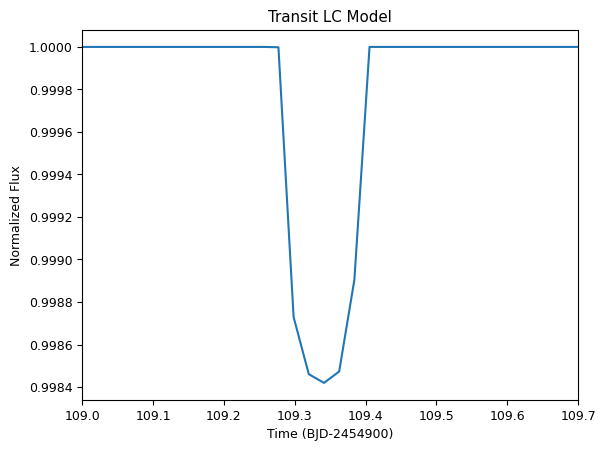

In [15]:
time = time
flux = flux

plt.plot(time, flux)
plt.xlim(109,109.7)
plt.xlabel('Time (BJD-2454900)')
plt.ylabel('Normalized Flux')
plt.title('Transit LC Model')

To create a light curve with a target signal to noise ratio, we need the transit duration, number of transits, and the number of points in each transit, and the transit depth.

In [16]:
tduration = koi.dur/24.0

N = round(ph.get_N_intransit(tduration, cadence))
ntransits = len(koi.midpoints)
depth = koi.rprs**2

The magnitude of each individual error bar:

In [17]:
errbar = ph.get_sigma_individual(60, N, ntransits, depth)

Adding gaussian noise to produce a light curve with the target SNR:

(NB: the noise is gaussian and uncorrelated, unlike the noise in real Kepler light curves)

In [18]:
noise = np.random.normal(0,errbar,len(time))
nflux = flux+noise

flux_err = np.array([errbar]*len(nflux))

Text(0.5, 1.0, 'Transit LC Model with Noise')

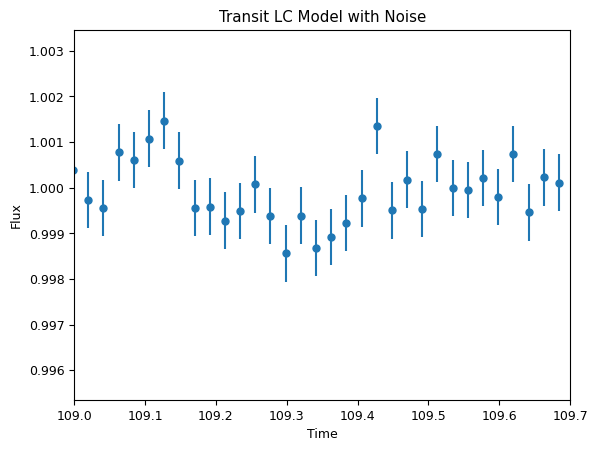

In [19]:
plt.errorbar(time, nflux, yerr=flux_err, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.xlim(109,109.7)
plt.title('Transit LC Model with Noise')

### Getting the stellar density prior

In [20]:
koi.rho_star = ph.get_rho_prior(koi.period, koi.rprs, koi.a_rs, koi.i, e, w)
koi.rho_star_err = 1

In [21]:
koi.rho_star

3.2337248184593266

### Fitting the transit


`photoeccentric` includes functionality to fit using `exoplanet`.

First, I'll fit the transit shape with `exoplanet`. $P$, $t0$, $Rp/Rs$, $rho_star$, $b$, $sesinw$ and $secosw$ are allowed to vary as free parameters. 

In [22]:
koi.time = time
koi.flux = nflux
koi.flux_err = flux_err

Let's just do the first 7 transits.

In [23]:
koi.midpoints = koi.midpoints[0:7]

In [24]:
koi.remove_oot_data(7, 6)

100%|██████████| 7/7 [00:00<00:00, 1186.84it/s]


Text(0.5, 1.0, 'Transit LC Model with Noise')

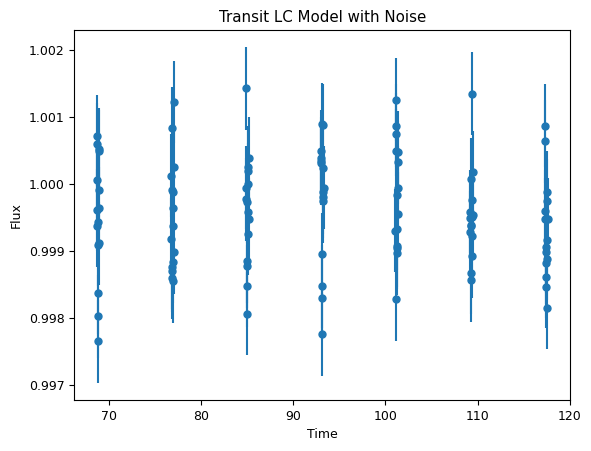

In [25]:
plt.errorbar(koi.time_intransit, koi.flux_intransit, yerr=koi.fluxerr_intransit, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Transit LC Model with Noise')

In [26]:
nsupersample=29
exptimesupersample=0.0201389

In [37]:
trace = koi.do_tfit_exoplanet(oversample=nsupersample, exptime=exptimesupersample, tune=4000, draw=2000)
trace.to_netcdf(direct + "trace.nc")

Sequential sampling (2 chains in 1 job)
NUTS: [ecs, ror, rho_star, q2, q1, b, t0, period]


Sampling 2 chains for 4_000 tune and 2_000 draw iterations (8_000 + 4_000 draws total) took 22809 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9835385009056289, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


'tutorial01_Test/818.01/e_0.0_w_90.0/trace.nc'


Below, I plot the transit fit corner plot.

Because I input $e = 0.0$, the transit fitter should return close to the same parameters I input (because the transit fitter always requires $e = 0.0$).

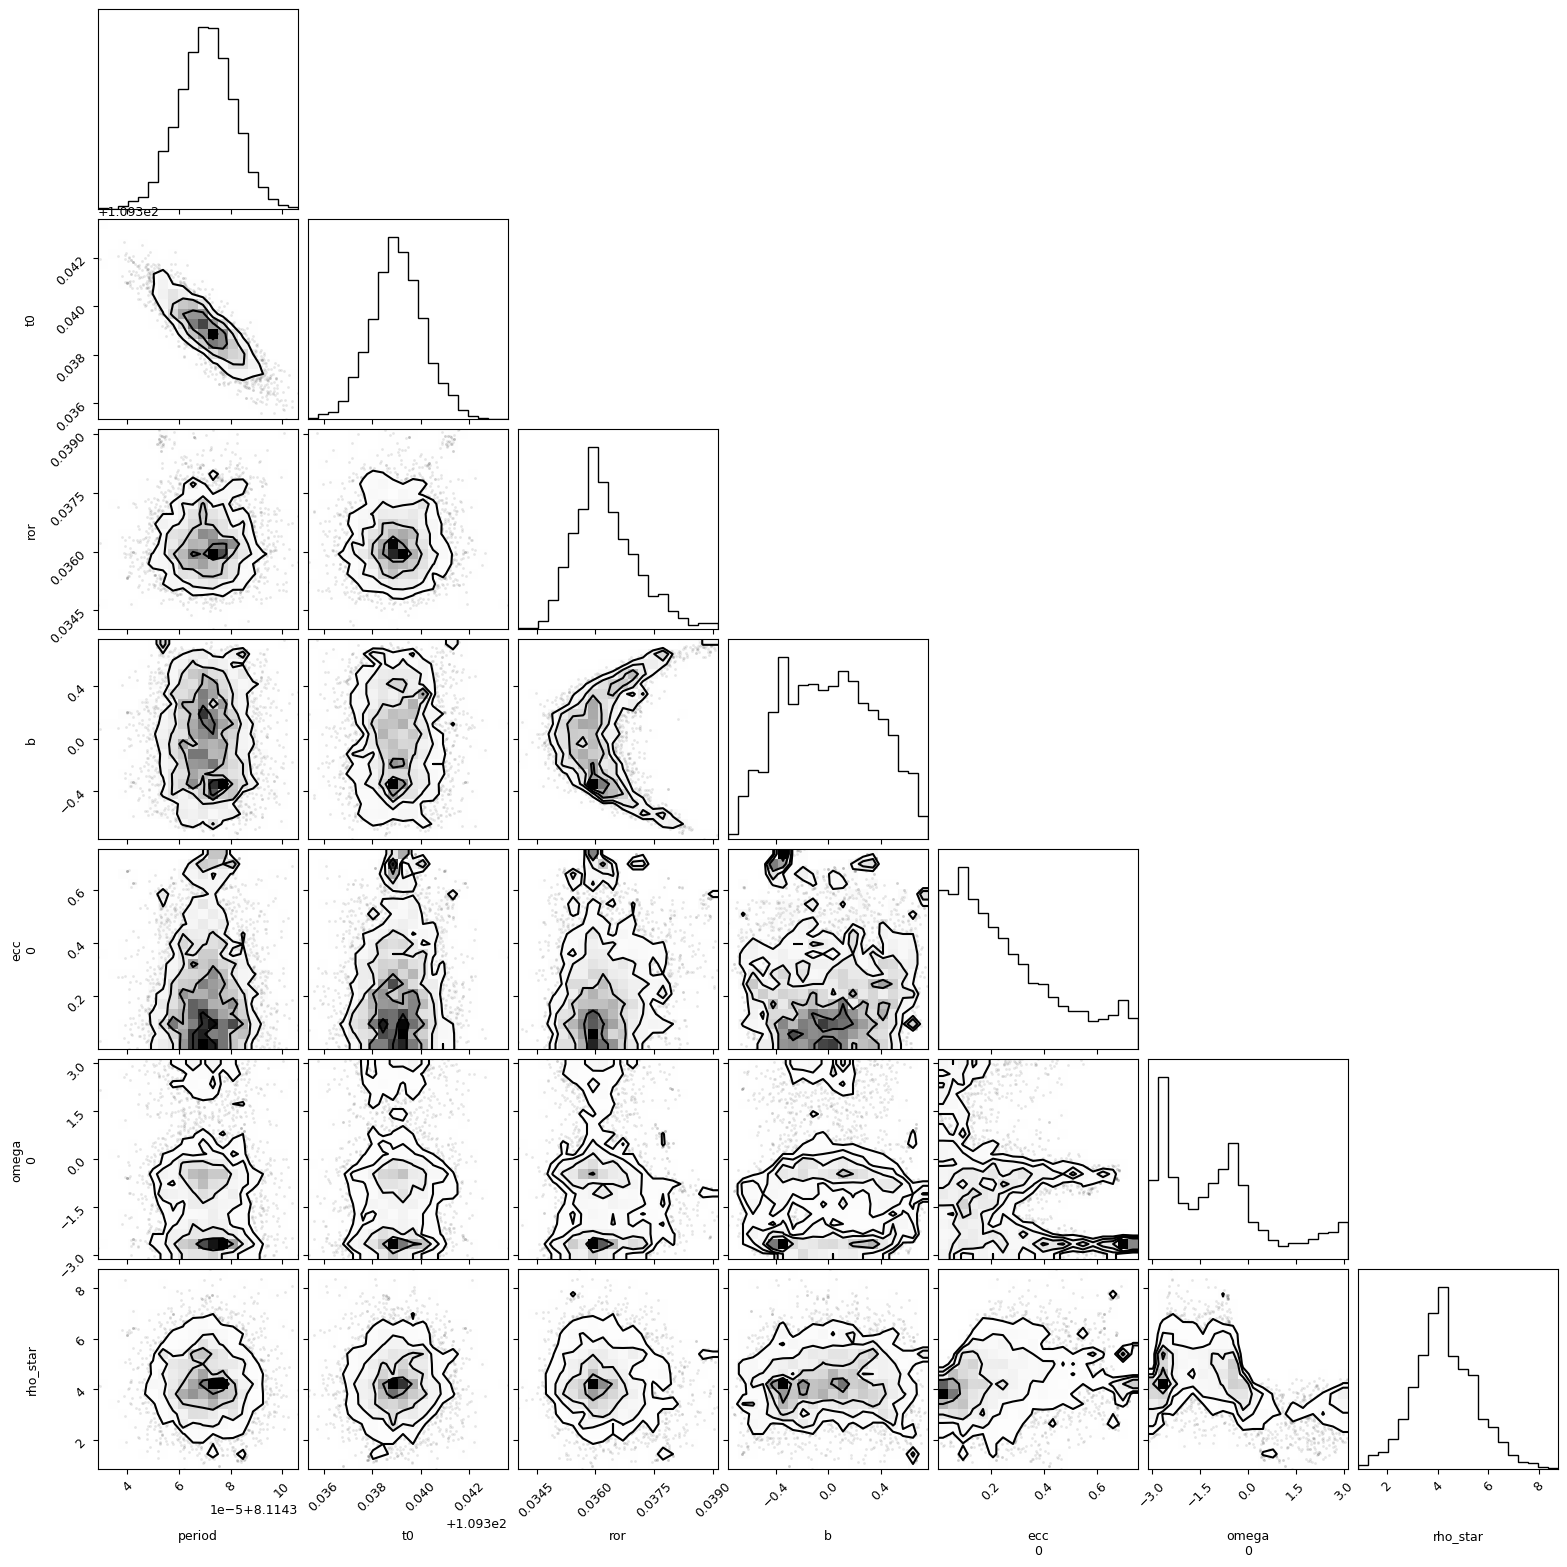

In [36]:
_ = corner.corner(trace, var_names=['period', 't0', 'ror', 'b', 'ecc', 'omega', 'rho_star'])

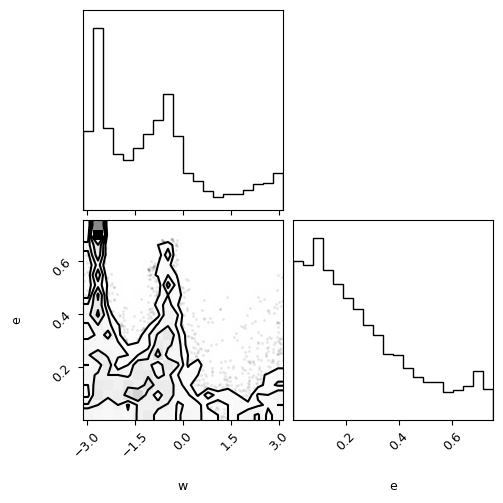

In [35]:
labels = ["w", "e"]

fs = np.vstack((samples["omega"].values, samples["ecc"].values))
fs = fs.T

fig = corner.corner(fs, labels=labels)

And here is the corner plot for the most likely values of $(e, w)$. The $e$ distribution peaks at 0!

## Test Case 2: $e = 0.3$, $\omega = 90.0$

Now let's repeat this example with an eccentricity of 0.3 at periapse.

In [64]:
# Define the working directory
direct = 'tutorial01/' + str(nkoi) + '/e_0.3_w_90.0/'

First, downloading the light curves

In [ ]:
# Stitching the light curves together, preserving the time stamps
koi.download_lightcurves()
koi.get_stitched_lcs()

# Getting the midpoint times
koi.get_midpoints()

COMPLETE:  mastDownload.tar.gz


In [ ]:
starttime = koi.time[0]
endtime = koi.time[-1]

In [ ]:
# 30 minute cadence
cadence = 0.02142857142857143

time = np.arange(starttime, endtime, cadence)

In [ ]:
# Define e and w, calculate flux from transit model
e = 0.3
w = 90.0
import batman 

params = batman.TransitParams()       #object to store transit parameters
params.t0 = koi.epoch                 #time of inferior conjunction
params.per = koi.period               #orbital period
params.rp = koi.rprs                  #planet radius (in units of stellar radii)
params.a = koi.a_rs                   #semi-major axis (in units of stellar radii)
params.inc = koi.i                    #orbital inclination (in degrees)
params.ecc = e                        #eccentricity
params.w = w                          #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = time
m = batman.TransitModel(params, t, supersample_factor = 29, exp_time = 0.0201389)

In [ ]:
flux = m.light_curve(params)

Text(0.5, 1.0, 'Transit LC Model')

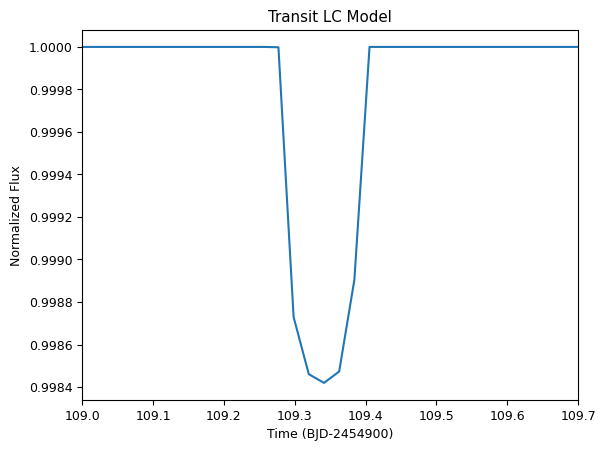

In [ ]:
time = time
flux = flux

plt.plot(time, flux)
plt.xlim(109,109.7)
plt.xlabel('Time (BJD-2454900)')
plt.ylabel('Normalized Flux')
plt.title('Transit LC Model')

To create a light curve with a target signal to noise ratio, we need the transit duration, number of transits, and the number of points in each transit, and the transit depth.

In [ ]:
tduration = koi.dur/24.0

N = round(ph.get_N_intransit(tduration, cadence))
ntransits = len(koi.midpoints)
depth = koi.rprs**2

The magnitude of each individual error bar:

In [ ]:
errbar = ph.get_sigma_individual(60, N, ntransits, depth)

Adding gaussian noise to produce a light curve with the target SNR:

(NB: the noise is gaussian and uncorrelated, unlike the noise in real Kepler light curves)

In [ ]:
noise = np.random.normal(0,errbar,len(time))
nflux = flux+noise

flux_err = np.array([errbar]*len(nflux))

Text(0.5, 1.0, 'Transit LC Model with Noise')

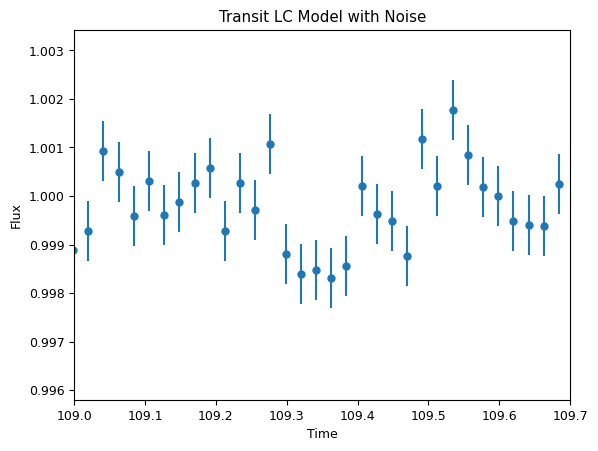

In [ ]:
plt.errorbar(time, nflux, yerr=flux_err, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.xlim(109,109.7)
plt.title('Transit LC Model with Noise')

### Getting the stellar density prior

In [ ]:
koi.rho_star = ph.get_rho_prior(koi.period, koi.rprs, koi.a_rs, koi.i, e, w)
koi.rho_star_err = 1

In [ ]:
koi.rho_star

3.2337248184593266

### Fitting the transit


`photoeccentric` includes functionality to fit using `exoplanet`.

First, I'll fit the transit shape with `exoplanet`. $P$, $t0$, $Rp/Rs$, $rho_star$, $b$, $sesinw$ and $secosw$ are allowed to vary as free parameters. 

In [ ]:
koi.time = time
koi.flux = nflux
koi.flux_err = flux_err

Let's just do the first 7 transits.

In [ ]:
koi.midpoints = koi.midpoints[0:7]

In [ ]:
koi.remove_oot_data(7, 6)

100%|██████████| 7/7 [00:00<00:00, 1418.36it/s]


Text(0.5, 1.0, 'Transit LC Model with Noise')

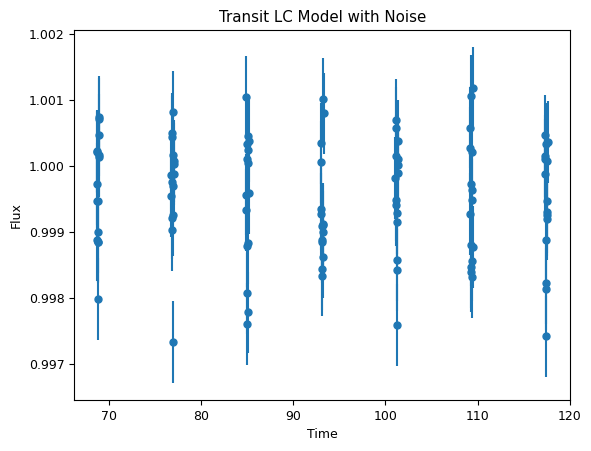

In [ ]:
plt.errorbar(koi.time_intransit, koi.flux_intransit, yerr=koi.fluxerr_intransit, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Transit LC Model with Noise')

In [ ]:
nsupersample=29
exptimesupersample=0.0201389

In [ ]:
trace = koi.do_tfit_exoplanet(oversample=nsupersample, exptime=exptimesupersample, tune=2000, draw=2000)

Sequential sampling (2 chains in 1 job)
NUTS: [ecs, ror, rho_star, q2, q1, b, t0, period]


In [ ]:
import arviz as az

az.summary(trace)

KeyboardInterrupt: 


Below, I plot the transit fit corner plot.

Because I input $e = 0.0$, the transit fitter should return close to the same parameters I input (because the transit fitter always requires $e = 0.0$).

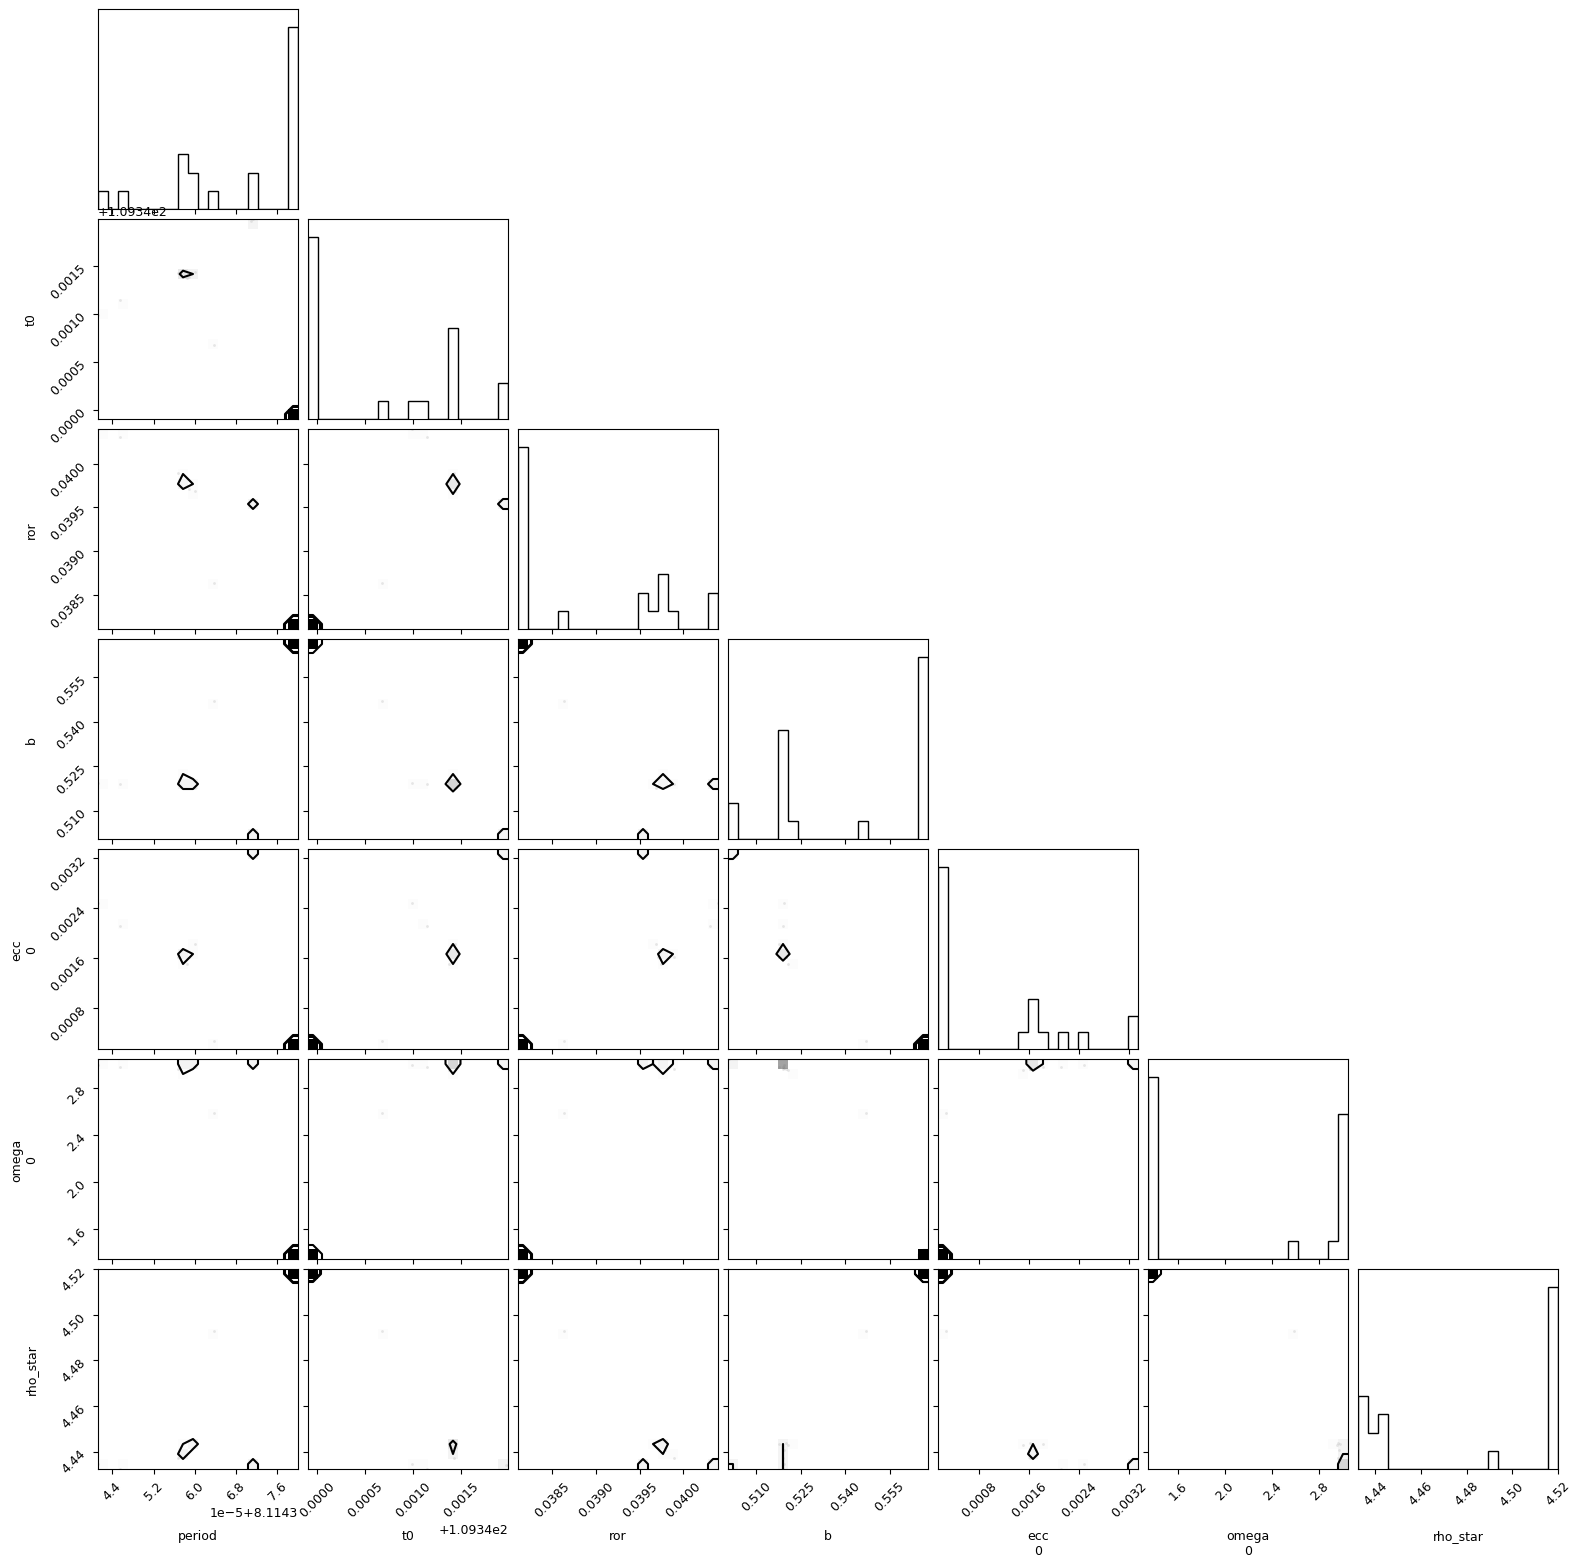

In [ ]:
_ = corner.corner(trace, var_names=['period', 't0', 'ror', 'b', 'ecc', 'omega', 'rho_star'])

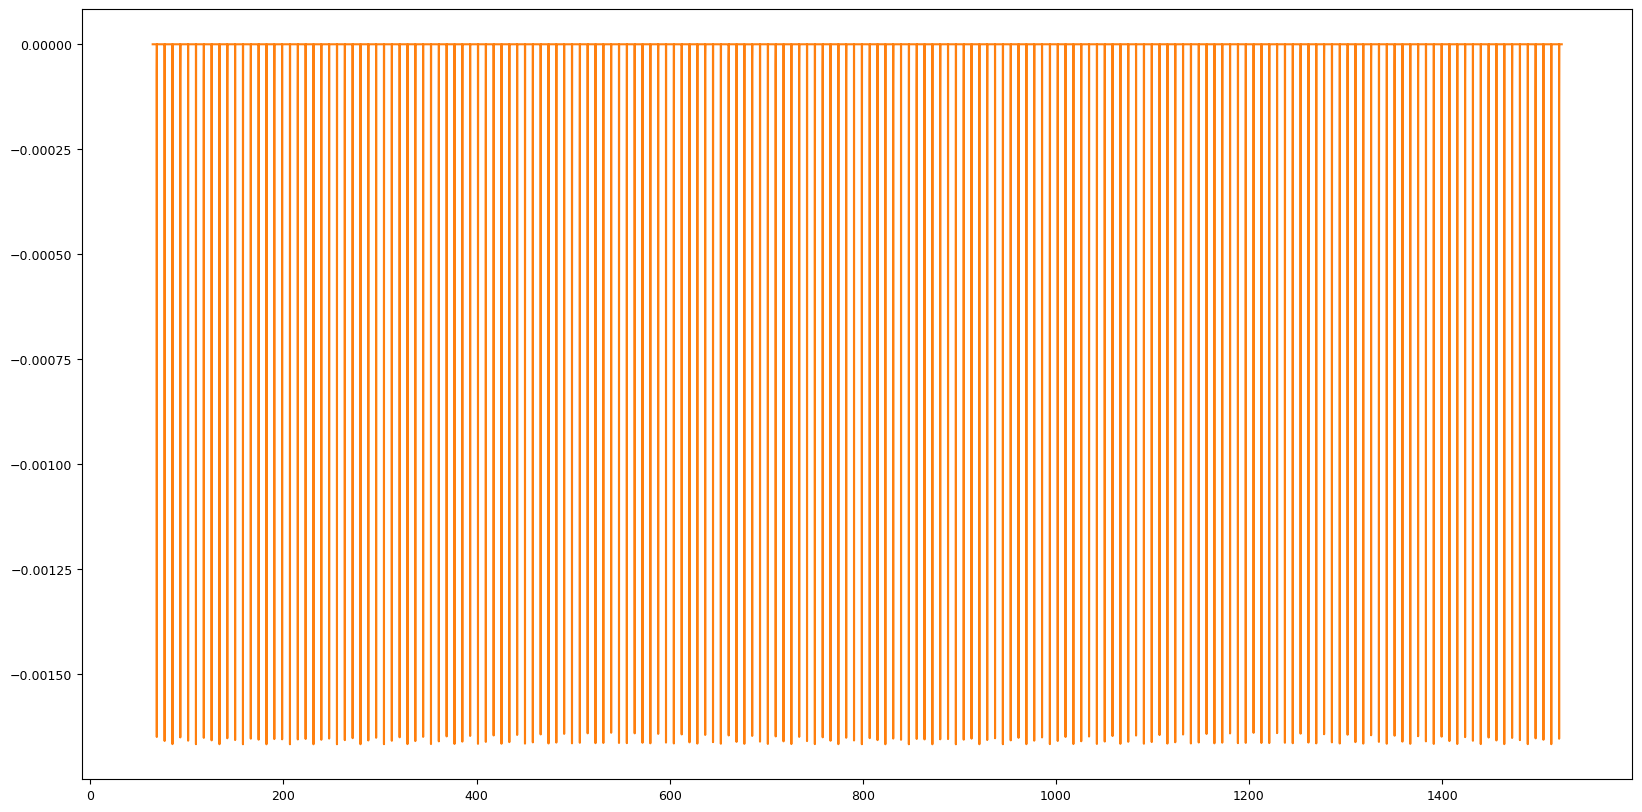

In [ ]:
samples = trace.posterior.stack(sample=("chain", "draw"))

# Get the posterior median orbital parameters
p = np.median(samples["period"])
t0 = np.median(samples["t0"])
rprs = np.median(samples["ror"])
b = np.median(np.abs(samples["b"]))
ecc = np.median(samples["ecc"])
omega = np.median(samples["omega"])


# Plot the folded model
pred = np.percentile(samples["light_curves"], [16, 50, 84], axis=-1)
plt.plot(koi.time, pred[1], color="C1", label="model")

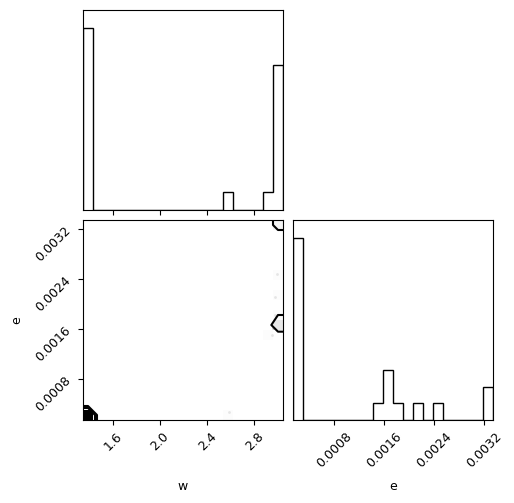

In [ ]:
labels = ["w", "e"]

fs = np.vstack((samples["omega"].values, samples["ecc"].values))
fs = fs.T

fig = corner.corner(fs, labels=labels)

And here is the corner plot for the most likely values of $(e, w)$. The $e$ distribution peaks at 0!